In [20]:
import pyro
import torch
pyro.set_rng_seed(101)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Primitive Stochastic Functions

primitive stochastic function を使うのは簡単。例えば、標準ガウス分布からあるサンプル `x` を得るには、次のようにします。

In [45]:
loc = 10.
scale = 1.
normal = torch.distributions.Normal(loc, scale)

x = normal.rsample([1000])

print('sample:', x[:10])

sample: tensor([10.6217,  9.1694, 10.3198,  8.4685,  9.7954,  9.0938,  8.9466,  9.5417,
         9.7617, 10.4102])


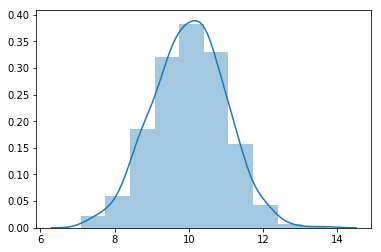

In [46]:
sns.distplot(x, bins=10)

ここで、`torch.distributions.Normal` は `Distributions` クラスのインスタンスで、パラメータを引数に取り、サンプルとスコアに関する関数を提供します。Pyro の分布に関するライブラリ `pyro.distributions` は `torch.distributions` の簡単なラッパーとなっており、これは PyTorch の持つ強力なテンソル演算と自動微分の能力を推論の際に使用したいからです。

In [3]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {
        'cloudy': 55.0, 'sunny': 75.0
    }[cloudy]
    scale_temp = {
        'cloudy': 10.0, 'sunny': 15.0
    }[cloudy]
    
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

In [5]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(0.9544)


In [6]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {
        'cloudy': 55.0, 'sunny': 75.0
    }[cloudy]
    scale_temp = {
        'cloudy': 10.0, 'sunny': 15.0
    }[cloudy]
    
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

In [7]:
for _ in range(3):
    print(weather())

('sunny', 94.37557983398438)
('sunny', 72.5186767578125)
('cloudy', 54.18292999267578)


In [10]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.))
    return ice_cream

これくらいのモジュール化はプログラマにとっては当たり前かもしれませんが、非常に強力で

In [12]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t+1)
    
print(geometric(0.5))

0


In [13]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.0))
    

tensor(0.5876)


In [76]:
def shinchoku():
    feeling = pyro.sample("feeling", pyro.distributions.Bernoulli(0.2))
    feeling = 'good' if feeling.item() == 1.0 else 'bad'
    loc, scale = {
        'good': (100, 10),
        'bad': (50, 30),
    }[feeling]
    return pyro.sample("progress", pyro.distributions.Normal(loc, scale))

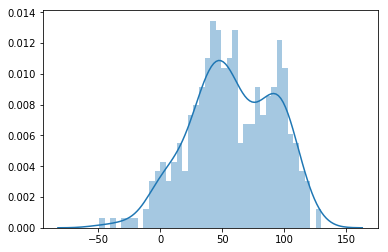

In [77]:
sns.distplot([shinchoku() for _ in range(365)], bins=40)

In [71]:
shinchoku()

tensor(16.8225)